Dan Yawitz

CUNY SPS / Data 622 - ML

12 October 2025

This assignment consists of conducting at least two (2) experiments for different algorithms: Decision Trees, Random Forest and Adaboost. That is, at least six (6) experiments in total (3 algorithms x 2 experiments each). For each experiment you will define what you are trying to achieve (before each run), conduct the experiment, and at the end you will review how your experiment went. These experiments will allow you to compare algorithms and choose the optimal model. 

Using the dataset and EDA from the previous assignment, perform the following
1. Algorithm Selection
2. Experiment 
3. Variations


In [4]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import (RepeatedStratifiedKFold, RandomizedSearchCV, cross_validate)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline


pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)


import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [5]:
df = pl.read_csv('../Assignment1-EDA/data/bank-additional/bank-additional-full-CLEANED.csv')

In [6]:
x_columns0 = ['age', 'education_n','job_n', 
            'default', 'housing', 'loan', 'campaign_n', 'previous', 'emp.var.rate', 'cons.conf.idx', 'euribor3m',
            'cons.price.idx', 'nr.employed']
dummies = [i for i in df.columns if ('day_of_week' in i or 'month' in i) and i not in ('month_n', 'month', 'day_of_week', 'day_of_week_n', 'day_of_week_cos', 'month_cos')]
dummies.append('contact_n')
x_columns = x_columns0 + dummies
len(x_columns)

29

In [7]:
y = df['y']
X = df[x_columns].clone()

# Assumptions
Rather than attempt to test every part of the model building process (feature selection, feature scaling, model selection, feature engienering, etc), this assignment focuses on the following processes:
- Model selection
- Hyperparameter tuning

The goal is to select the best model, with the best-tuned parameters.

In order to minimize experimental variation, we hold the following elements constant:
- Engineered features
- Scaled features

For each experiment we run the following:
- Select a model
- Selet a hyperparameter to tune (and range of values)
- apply `StratifiedKFolds` cross validation

# Functions

In [8]:
def run_cv_experiment(model, X, y, cv, experiment_name, experiment_num, 
                      features, scaler=None, notes=""):
    """
    Run cross-validation experiment and return results.
    Returns:
    dict : results dictionary
    """
    
    # Wrap in pipeline if scaler provided and model isn't already a pipeline
    if scaler is not None and not isinstance(model, Pipeline):
        model = Pipeline([
            ('scaler', scaler),
            ('model', model)
        ])
        
    # Run cross-validation
    cv_results = cross_validate(model, X, y, cv=cv, 
                                scoring=scoring, return_train_score=True,
                               return_estimator=True)

    test_scores = cv_results['test_f1']
    best_idx = test_scores.argmax()
    best_estimator = cv_results['estimator'][best_idx]
    
    # Compile results
    result = {
        'model': model,
        'best_estimator':best_estimator,
        'experiment': experiment_num,
        'experiment_name': experiment_name,
        'notes': notes,
    }
    
    # Add mean scores from cv_results
    for metric in scoring.keys():
        result[f'train_{metric}'] = round(cv_results[f'train_{metric}'].mean(), 4)
        result[f'test_{metric}'] = round(cv_results[f'test_{metric}'].mean(), 4)
        result[f'test_{metric}_std'] = round(cv_results[f'test_{metric}'].std(), 4)
    
    return result

def plot_random_search_results(search_results, experiment_name, model_name):
    """
    Plot F1 scores vs hyperparameters from RandomizedSearchCV results.
    Shows all CV fold scores as scattered dots for each parameter.
    Creates a subplot for each hyperparameter tested.
    """
    cv_results = search_results.cv_results_
    
    # Get parameter names (exclude 'random_state' and 'class_weight')
    param_cols = [col for col in cv_results.keys() if col.startswith('param_') 
                  and 'random_state' not in col and 'class_weight' not in col]
    
    if len(param_cols) == 0:
        return
    
    n_params = len(param_cols)
    
    # Get number of CV splits
    n_splits = search_results.n_splits_
    
    # Extract individual fold scores
    train_scores_all = []
    test_scores_all = []
    
    for split_idx in range(n_splits):
        train_key = f'split{split_idx}_train_f1'
        test_key = f'split{split_idx}_test_f1'
        if train_key in cv_results and test_key in cv_results:
            train_scores_all.append(cv_results[train_key].tolist())
            test_scores_all.append(cv_results[test_key].tolist())
    
    # Get best result
    mean_test_f1 = cv_results['mean_test_f1'].tolist()
    best_idx = np.argmax(mean_test_f1)
    best_test_f1 = mean_test_f1[best_idx]
    
    # Create subplots
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 3*n_params))
    if n_params == 1:
        axes = [axes]
    
    fig.suptitle(f'{model_name}\n{experiment_name}', fontsize=14, fontweight='bold', y=1.02)
    
    # Process each parameter
    for param_idx, param_col in enumerate(param_cols):
        ax = axes[param_idx]
        
        # Get param name without 'param_' prefix
        param_name = param_col.replace('param_', '')
        
        # Get parameter values
        param_vals = cv_results[param_col].data.tolist()
        
        # Convert None strings to actual None and handle conversions
        param_vals_cleaned = []
        for val in param_vals:
            if val == 'None' or val is None:
                param_vals_cleaned.append(None)
            else:
                try:
                    param_vals_cleaned.append(float(val))
                except (ValueError, TypeError):
                    param_vals_cleaned.append(val)
        
        # Get unique parameter values and create mapping
        unique_params = sorted(set(param_vals_cleaned), 
                              key=lambda x: (x is None, x))
        param_to_idx = {p: i for i, p in enumerate(unique_params)}
        
        # Get best parameter value for this parameter
        best_param_val = param_vals_cleaned[best_idx]
        
        # Plot all individual CV fold scores
        for split_idx in range(len(train_scores_all)):
            for run_idx in range(len(param_vals_cleaned)):
                param_val = param_vals_cleaned[run_idx]
                x_pos = param_to_idx[param_val]
                
                # Add small random jitter for visibility
                jitter = np.random.uniform(-0.15, 0.15)
                
                # Plot train score
                ax.scatter(x_pos + jitter, train_scores_all[split_idx][run_idx],
                          alpha=0.3, s=30, color='blue')
                
                # Plot test score
                ax.scatter(x_pos + jitter, test_scores_all[split_idx][run_idx],
                          alpha=0.3, s=30, color='orange')
        
        # Add legend entries (only on first subplot)
        if param_idx == 0:
            ax.scatter([], [], alpha=0.6, s=50, color='blue', label='Train F1')
            ax.scatter([], [], alpha=0.6, s=50, color='orange', label='Test F1')
            ax.scatter([], [], color='red', s=150, marker='*', label='Best model')
        
        # Mark best model with red star
        best_x_pos = param_to_idx[best_param_val]
        ax.scatter(best_x_pos, best_test_f1, 
                  color='red', s=300, marker='*', 
                  zorder=10, edgecolors='darkred', linewidths=1.5)
        
        # Set x-axis
        ax.set_xticks(range(len(unique_params)))
        ax.set_xticklabels([str(p) for p in unique_params], 
                           rotation=45, ha='right', fontsize=9)
        ax.set_xlabel(param_name, fontsize=11, fontweight='bold')
        
        if param_idx == 0:
            ax.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
            ax.legend(fontsize=9, loc='best')
        
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()





def run_randomized_search(model_class, param_distributions, X, y, cv, 
                          experiment_name, experiment_num, features,
                          n_iter=20, scaler=None, base_params=None):
    """
    Run randomized hyperparameter search and return best model results.
    
    Returns:
    dict : best model results with all metrics
    """
    if base_params is None:
        base_params = {}
    
    # Merge base params into param distributions
    full_params = base_params.copy()
    
    # Create model instance
    model = model_class(random_state=42, **base_params)
    
    # Wrap in pipeline if scaler provided
    if scaler is not None:
        model = Pipeline([
            ('scaler', scaler),
            ('model', model)
        ])
        
        # Prefix param names with 'model__' if not already done
        param_distributions = {
            f'model__{k}' if not k.startswith('model__') else k: v 
            for k, v in param_distributions.items()
        }    
    # Run randomized search
    search = RandomizedSearchCV(
        model, 
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        refit='f1',
        random_state=42,
        n_jobs=-1,
        return_train_score=True
    )
    
    search.fit(X, y)
    
    # Plot results
    model_name = model_class.__name__
    plot_random_search_results(search, experiment_name, model_name)
    
    # Get best model and evaluate
    best_model = search.best_estimator_
    
    # Extract best params without pipeline prefix for display
    best_params_clean = {}
    for k, v in search.best_params_.items():
        if k.startswith('model__'):
            best_params_clean[k.replace('model__', '')] = v
        else:
            best_params_clean[k] = v

    # Run cross-validation on best model to get consistent metrics
    result = run_cv_experiment(
        best_model, X, y, cv,
        experiment_name=experiment_name,
        experiment_num=experiment_num,
        features=features,
        notes=f"Best params: {best_params_clean}"
    )

    result['best_params'] = best_params_clean
    result['best_estimator'] = best_model

    print(f"\n{experiment_name}")
    print(f"Best parameters: {best_params_clean}")
    print(f"Best F1 score: {result['test_f1']:.4f}")

    return result

# Initial conditions

In [9]:
# Initialize results storage. I'll store results objects here. 
all_results = []

# Define scoring metrics to use for all models
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Use the same stratified KFolds for each experiment 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

## Experiment 0: Control
All experiments need a control case. I test an un-tuned version of each of our models to indicate which models are most powerful out of the box

In [10]:
control_results = []
for model_class in [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier]:
    base_params = {"random_state": 42, 'class_weight': 'balanced'}
    model = model_class(random_state=42)

    # Tune scaler within cross validation
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])
    
    result = run_cv_experiment(
        pipeline, X, y, cv, 
        experiment_name=f"{model_class.__name__} (Control)",
        experiment_num=0,
        features=x_columns,
        notes="Baseline with CV"
    )
    control_results.append(result)
    all_results.append(result)

control_results_df = pl.DataFrame(control_results)
print(control_results_df.select(['experiment_name', 'test_accuracy', 'train_precision','test_precision', 'train_recall','test_recall', 'train_f1','test_f1','train_roc_auc', 'test_roc_auc']))

shape: (4, 10)
┌─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬────────┐
│ experim ┆ test_ac ┆ train_p ┆ test_pr ┆ train_r ┆ test_re ┆ train_f ┆ test_f1 ┆ train_r ┆ test_r │
│ ent_nam ┆ curacy  ┆ recisio ┆ ecision ┆ ecall   ┆ call    ┆ 1       ┆ ---     ┆ oc_auc  ┆ oc_auc │
│ e       ┆ ---     ┆ n       ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ f64     ┆ ---     ┆ ---    │
│ ---     ┆ f64     ┆ ---     ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆         ┆ f64     ┆ f64    │
│ str     ┆         ┆ f64     ┆         ┆         ┆         ┆         ┆         ┆         ┆        │
╞═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════╡
│ Logisti ┆ 0.8923  ┆ 0.5786  ┆ 0.5712  ┆ 0.1835  ┆ 0.1797  ┆ 0.2785  ┆ 0.273   ┆ 0.5833  ┆ 0.5812 │
│ cRegres ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆         ┆        │
│ sion    ┆         ┆         ┆         ┆         ┆         ┆         ┆     

Based on these early results, DecisionTree has the best recall and ROC_AUC score. 

Since our y class is so imbalanced (8:1), we care about these metrics more than we care about accuracy or precision. 

## Experiment 1: Decision Tree - tune hyperparams with RandomSearch
Let's tune a DecisionTree to the best of our ability. We'll run a randomsearch with cross validation and keep the best result

In [11]:
all_results = []

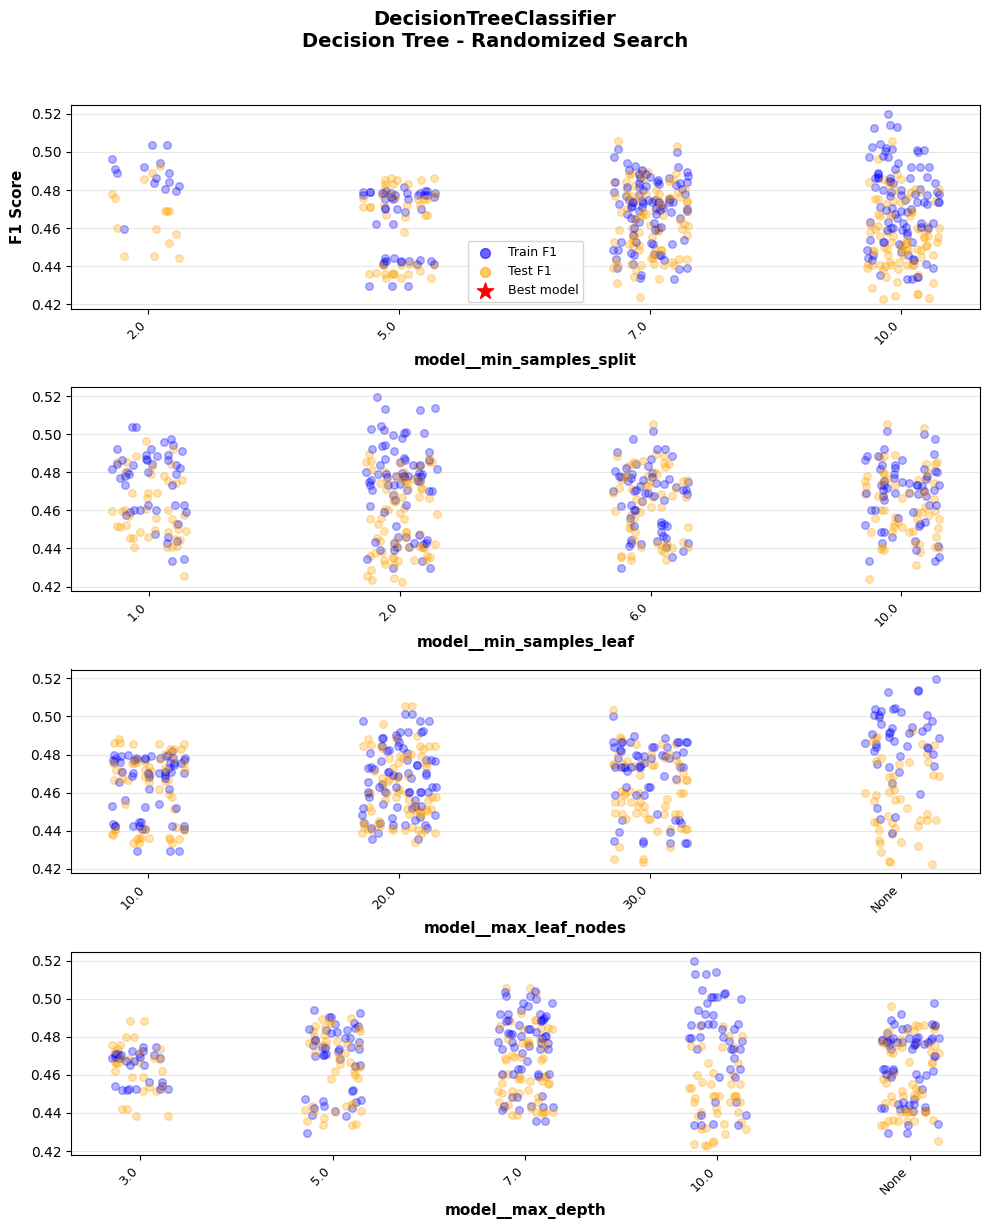


Decision Tree - Randomized Search
Best parameters: {'min_samples_split': 7, 'min_samples_leaf': 10, 'max_leaf_nodes': 30, 'max_depth': 7, 'class_weight': 'balanced'}
Best F1 score: 0.4715


In [12]:
param_dist_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 2, 6, 10],
    'max_leaf_nodes': [10, 20, 30, None],
    'min_samples_split': [2,5,7,10],
    'class_weight': ['balanced', 'balanced_subsample']
}

result1 = run_randomized_search(
    DecisionTreeClassifier,
    param_dist_dt,
    X, y, cv,
    experiment_name="Decision Tree - Randomized Search",
    experiment_num=1,
    features=x_columns,
    n_iter=30,
    scaler=MinMaxScaler()
)
all_results.append(result1)

## Experiment 2: Decision Tree - recursive feature elimination
Note that we need to exclude "max_features" for this to work correctly

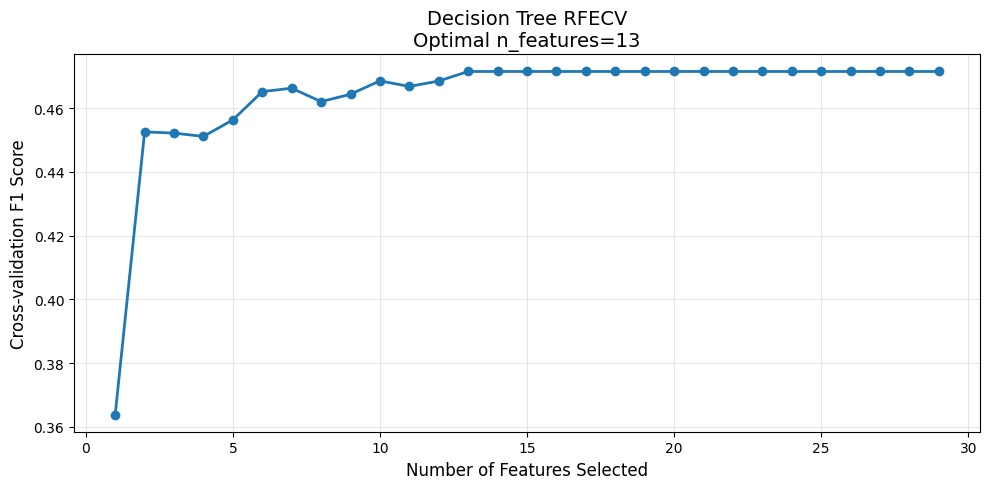


RFECV result: 13 features, F1=0.4703
Selected features: ['age', 'job_n', 'campaign_n', 'previous', 'emp.var.rate', 'cons.conf.idx', 'euribor3m', 'cons.price.idx', 'nr.employed', 'month_oct', 'day_of_week_mon', 'day_of_week_wed', 'contact_n']


In [13]:
# Use best params from Experiment 1
best_dt_params = result1['best_params'].copy()
best_dt_params.pop('max_features', None)
best_dt = DecisionTreeClassifier(random_state=42, **best_dt_params)

# Perform RFECV
rfecv_dt = RFECV(estimator=best_dt, step=1, cv=cv, scoring='f1', n_jobs=-1)
rfecv_dt.fit(X, y)

# Get selected features
selected_features_rfecv_dt = [x_columns[i] for i in range(len(x_columns)) if rfecv_dt.support_[i]]
X_rfecv_dt = X[:, rfecv_dt.support_]

# Evaluate with cross-validation
result2 = run_cv_experiment(
    best_dt, X_rfecv_dt, y, cv,
    experiment_name="Decision Tree RFECV",
    experiment_num=2,
    features=selected_features_rfecv_dt,
    scaler=MinMaxScaler(),
    notes=f"RFECV selected {rfecv_dt.n_features_} features"
)
result2['n_features'] = rfecv_dt.n_features_
all_results.append(result2)

# Plot RFECV results
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rfecv_dt.cv_results_['mean_test_score']) + 1),
         rfecv_dt.cv_results_['mean_test_score'], marker='o', linewidth=2)
plt.xlabel('Number of Features Selected', fontsize=12)
plt.ylabel('Cross-validation F1 Score', fontsize=12)
plt.title(f'Decision Tree RFECV\nOptimal n_features={rfecv_dt.n_features_}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nRFECV result: {rfecv_dt.n_features_} features, F1={result2['test_f1']:.4f}")
print(f"Selected features: {selected_features_rfecv_dt}")

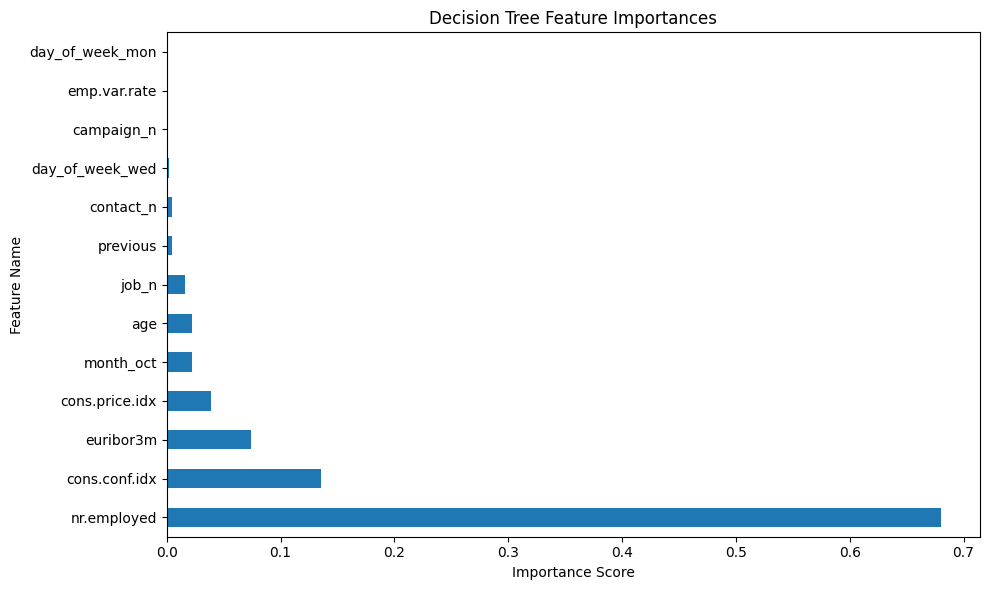

In [52]:
import pandas as pd
clf = result2['best_estimator']

mdl = clf.named_steps['model']
feature_importances = pd.Series(mdl.feature_importances_, clf.feature_names_in_)
sorted_importances = feature_importances.sort_values(ascending=False)
    
plt.figure(figsize=(10, 6))
sorted_importances.nlargest(20).plot(kind='barh')
plt.title('Decision Tree Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

## Experiment 3: Random Forest - tune hyperparameters

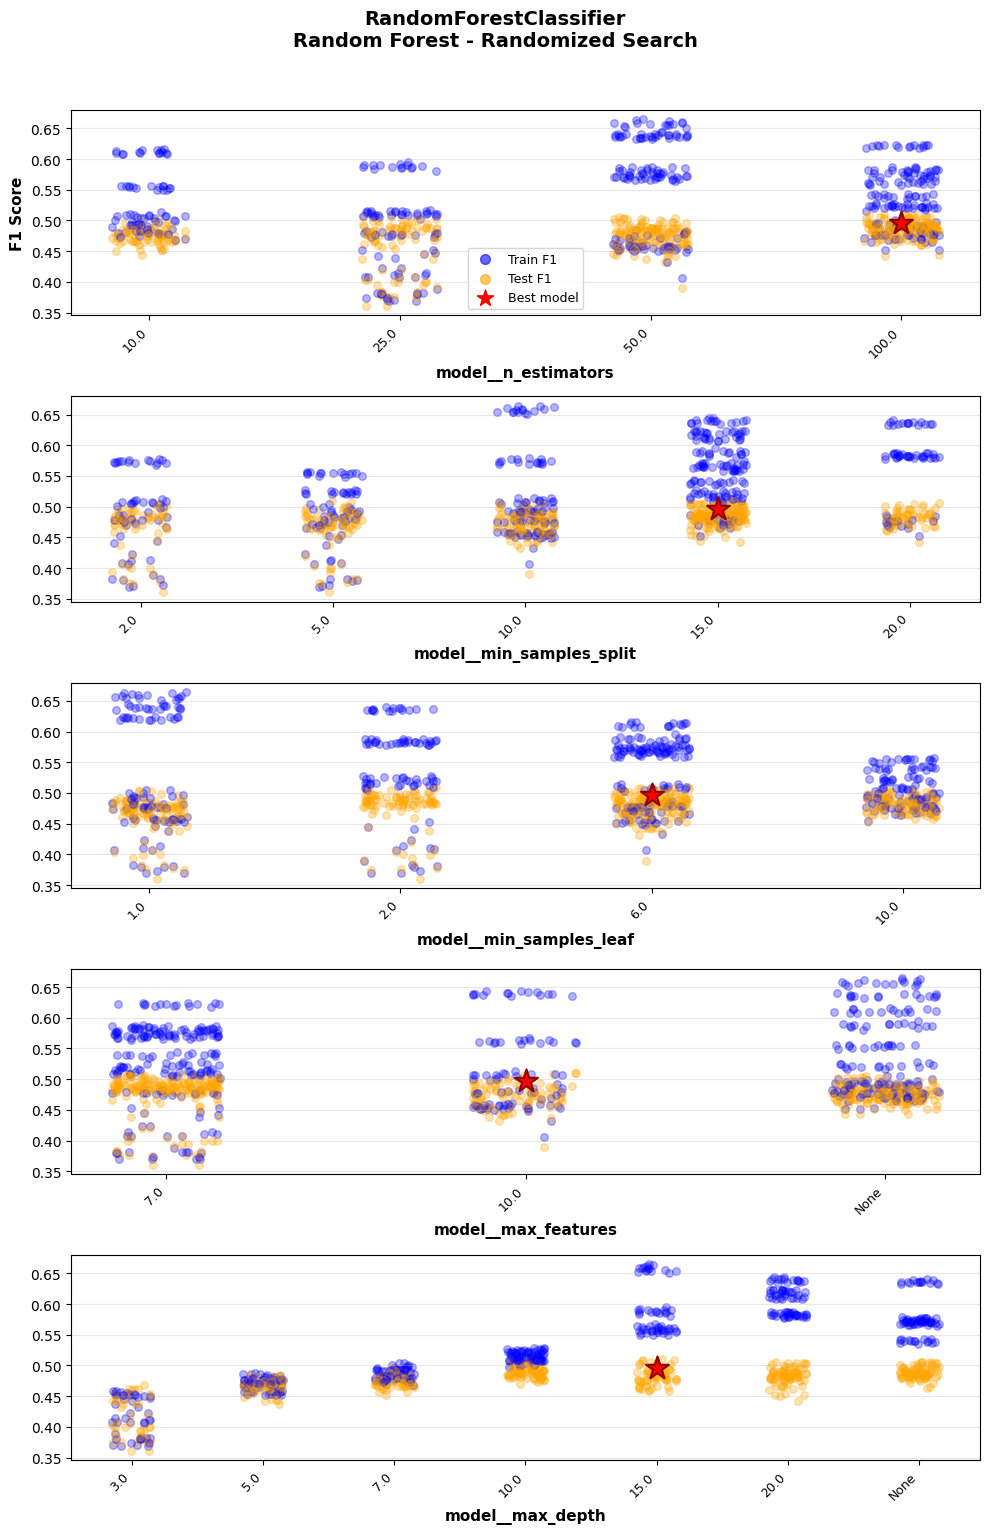


Random Forest - Randomized Search
Best parameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 10, 'max_depth': 15, 'class_weight': 'balanced_subsample'}
Best F1 score: 0.4963


In [14]:

param_dist_rf = {
    'n_estimators': [10, 25, 50, 100],
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 6, 10],
    'max_features': [7,10,None],
    'class_weight':['balanced_subsample', 'balanced']
    
}

result3 = run_randomized_search(
    RandomForestClassifier,
    param_dist_rf,
    X, y, cv,
    experiment_name="Random Forest - Randomized Search",
    experiment_num=3,
    features=x_columns,
    scaler=MinMaxScaler(),
    n_iter=30
)
all_results.append(result3)

## Experiment 4: Random Forest - Recursive Feature Elimination
Let's identify which features work the best with RandomForest

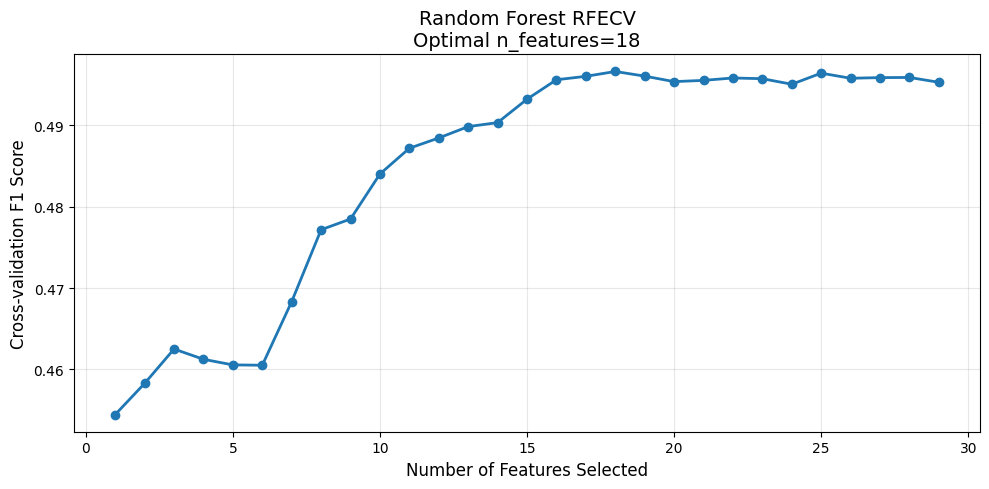


RFECV result: 18 features, F1=0.4965
Selected features: ['age', 'education_n', 'job_n', 'housing', 'loan', 'campaign_n', 'previous', 'emp.var.rate', 'cons.conf.idx', 'euribor3m', 'cons.price.idx', 'nr.employed', 'month_may', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_wed', 'contact_n']


In [15]:

# Use best params from Experiment 3
best_rf_params = result3['best_params'].copy()
best_rf_params.pop('max_features')
best_rf = RandomForestClassifier(random_state=42, **best_rf_params)

# Perform RFECV
rfecv = RFECV(estimator=best_rf, step=1, cv=cv, scoring='f1', n_jobs=-1)
rfecv.fit(X, y)

# Get selected features
selected_features_rfecv = [x_columns[i] for i in range(len(x_columns)) if rfecv.support_[i]]
X_rfecv = X[:, rfecv.support_]

# Evaluate with cross-validation
result4 = run_cv_experiment(
    best_rf, X_rfecv, y, cv,
    experiment_name="Random Forest RFECV",
    experiment_num=4,
    features=selected_features_rfecv,
    scaler=MinMaxScaler(),
    notes=f"RFECV selected {rfecv.n_features_} features"
)
result4['n_features'] = rfecv.n_features_
all_results.append(result4)

# Plot RFECV results
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'], marker='o', linewidth=2)
plt.xlabel('Number of Features Selected', fontsize=12)
plt.ylabel('Cross-validation F1 Score', fontsize=12)
plt.title(f'Random Forest RFECV\nOptimal n_features={rfecv.n_features_}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nRFECV result: {rfecv.n_features_} features, F1={result4['test_f1']:.4f}")
print(f"Selected features: {selected_features_rfecv}")


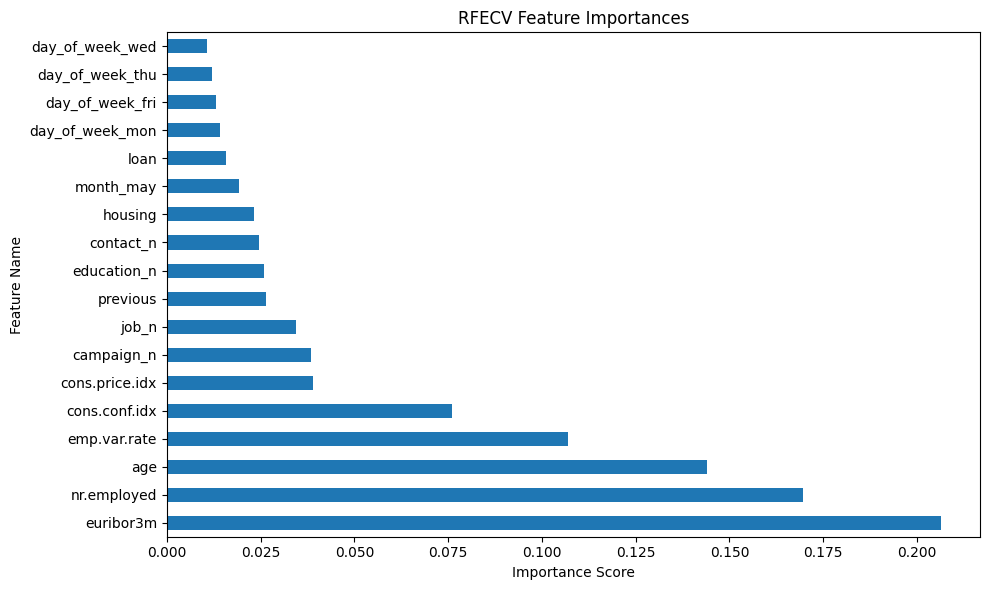

In [51]:
import pandas as pd
clf = result4['best_estimator']

mdl = clf.named_steps['model']
feature_importances = pd.Series(mdl.feature_importances_, clf.feature_names_in_)
sorted_importances = feature_importances.sort_values(ascending=False)
    
plt.figure(figsize=(10, 6))
sorted_importances.nlargest(20).plot(kind='barh')
plt.title('RFECV Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

## Experiment 5: Adaboost - tune max depth

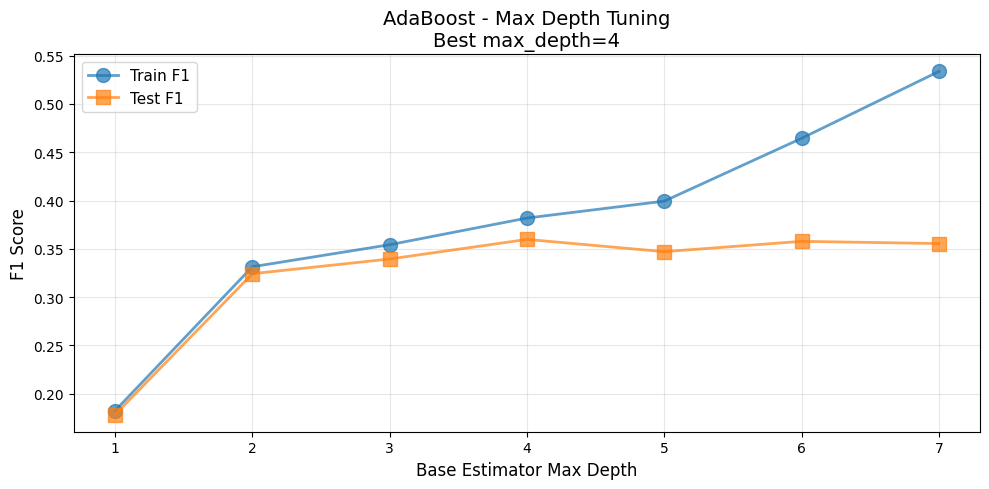


Best max_depth: 4, F1=0.3598


In [16]:

# Test max_depth values for base estimator
max_depths = [1, 2, 3, 4, 5, 6, 7]
ada_depth_results = []

for depth in max_depths:
    base_estimator = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model = AdaBoostClassifier(estimator=base_estimator, random_state=42)
    
    result = run_cv_experiment(
        model, X, y, cv,
        experiment_name=f"AdaBoost (max_depth={depth})",
        experiment_num=5,
        features=x_columns,
        scaler=MinMaxScaler(),
        notes=f"Base estimator max_depth={depth}"
    )
    result['max_depth'] = depth
    ada_depth_results.append(result)

# Find best depth
best_depth_idx = np.argmax([r['test_f1'] for r in ada_depth_results])
result5 = ada_depth_results[best_depth_idx]
all_results.append(result5)
best_ada_depth = result5['max_depth']

# Plot depth results
depths = [r['max_depth'] for r in ada_depth_results]
test_f1 = [r['test_f1'] for r in ada_depth_results]
train_f1 = [r['train_f1'] for r in ada_depth_results]

plt.figure(figsize=(10, 5))
plt.plot(depths, train_f1, marker='o', linewidth=2, markersize=10, 
         label='Train F1', alpha=0.7)
plt.plot(depths, test_f1, marker='s', linewidth=2, markersize=10, 
         label='Test F1', alpha=0.7)
plt.xlabel('Base Estimator Max Depth', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title(f'AdaBoost - Max Depth Tuning\nBest max_depth={best_ada_depth}', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(depths)
plt.tight_layout()
plt.show()

print(f"\nBest max_depth: {best_ada_depth}, F1={result5['test_f1']:.4f}")

## Experiment 6: Adaboost - tune learning rate

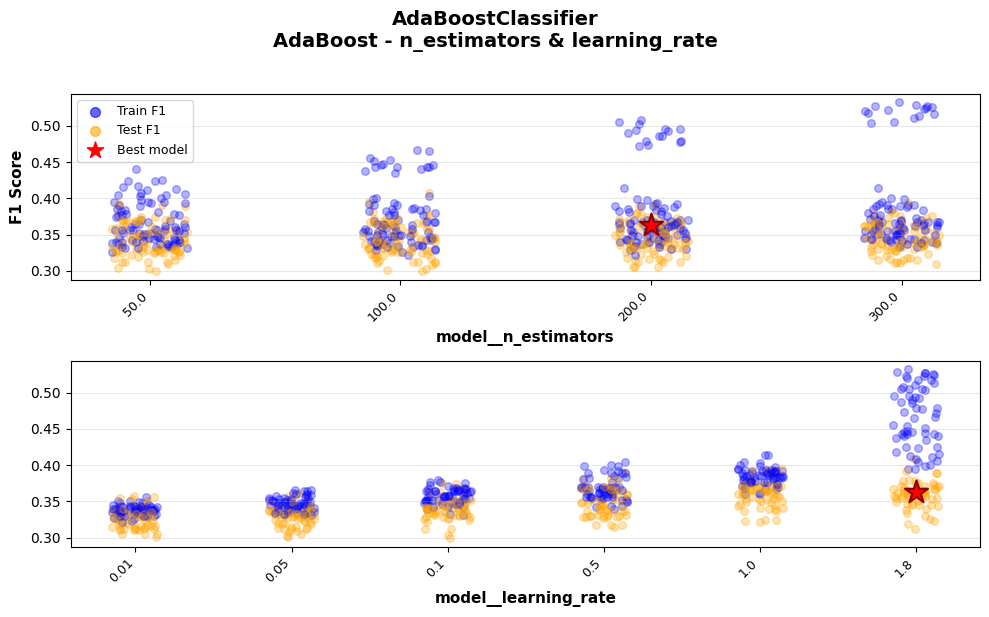


AdaBoost - n_estimators & learning_rate
Best parameters: {'n_estimators': 200, 'learning_rate': 1.8}
Best F1 score: 0.3630


In [17]:

# Use best max_depth from Experiment 5
base_estimator = DecisionTreeClassifier(max_depth=best_ada_depth, random_state=42)

param_dist_ada = {
    'n_estimators': [50,100,200,300],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0, 1.8]
}

result6 = run_randomized_search(
    AdaBoostClassifier,
    param_dist_ada,
    X, y, cv,
    experiment_name="AdaBoost - n_estimators & learning_rate",
    experiment_num=6,
    features=x_columns,
    scaler=MinMaxScaler(),
    n_iter=30,
    base_params={'estimator': base_estimator}
)
all_results.append(result6)


## Results

In [18]:
results_df = pl.DataFrame(all_results)
results_df = results_df.sort('test_f1', descending=True).unique(subset=['experiment'], keep="first")

In [19]:
with pl.Config(tbl_width_chars=130):
    print(results_df.sort('experiment').select(['experiment','experiment_name', 'test_accuracy', 'train_precision','test_precision', 'train_recall','test_recall', 'train_f1','test_f1', 'train_roc_auc','test_roc_auc']))

shape: (6, 11)
┌───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬──────────┬─────────┬───────────┬───────────┐
│ experimen ┆ experimen ┆ test_accu ┆ train_pre ┆ test_prec ┆ train_rec ┆ test_reca ┆ train_f1 ┆ test_f1 ┆ train_roc ┆ test_roc_ │
│ t         ┆ t_name    ┆ racy      ┆ cision    ┆ ision     ┆ all       ┆ ll        ┆ ---      ┆ ---     ┆ _auc      ┆ auc       │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ f64      ┆ f64     ┆ ---       ┆ ---       │
│ i64       ┆ str       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆          ┆         ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪══════════╪═════════╪═══════════╪═══════════╡
│ 1         ┆ Decision  ┆ 0.8433    ┆ 0.3865    ┆ 0.3818    ┆ 0.6277    ┆ 0.6189    ┆ 0.4778   ┆ 0.4715  ┆ 0.7502    ┆ 0.7454    │
│           ┆ Tree -    ┆           ┆           ┆           ┆       

In [32]:
results_df.sort('experiment').select(['experiment','experiment_name', 'test_accuracy', 'train_precision','test_precision', 'train_recall','test_recall', 'train_f1','test_f1', 'train_roc_auc','test_roc_auc']).write_csv('results.csv')

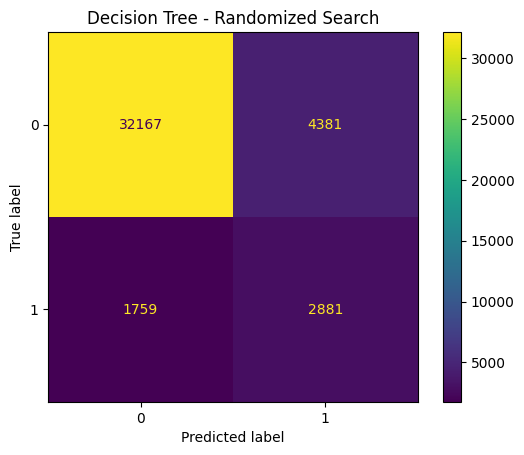

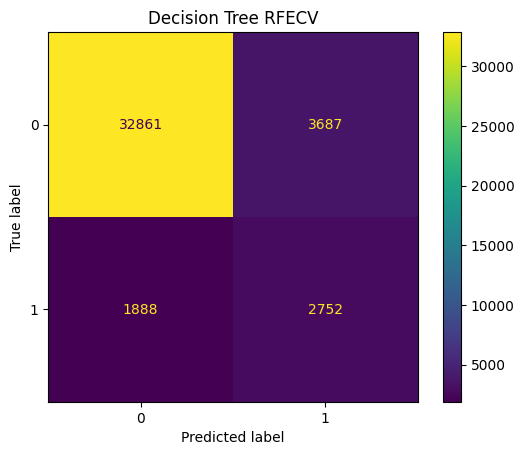

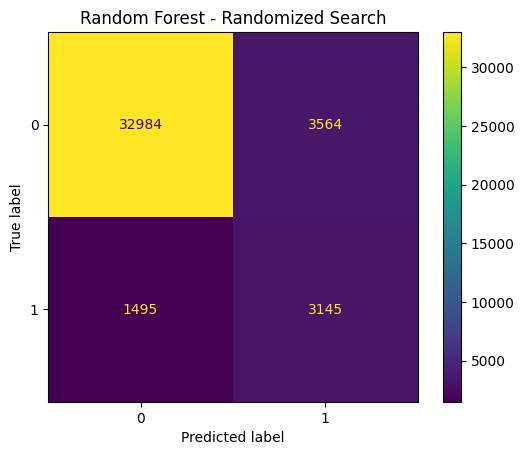

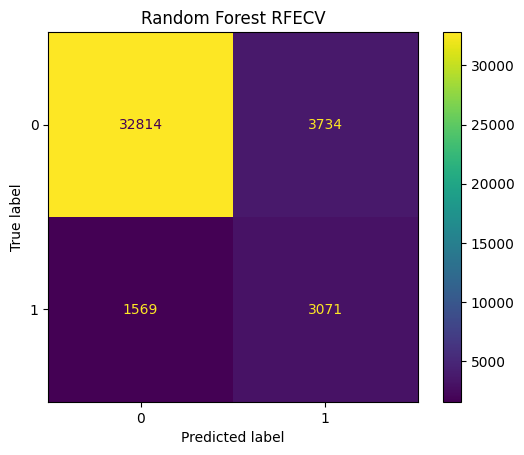

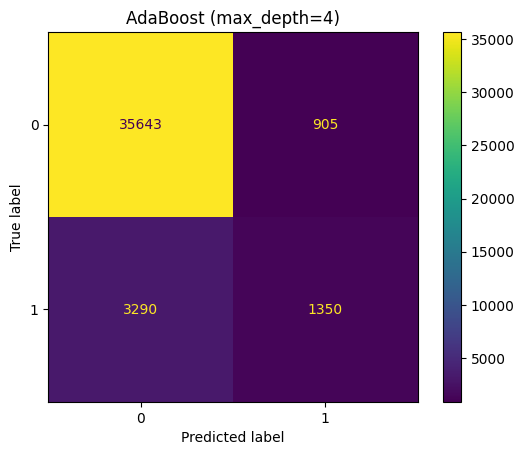

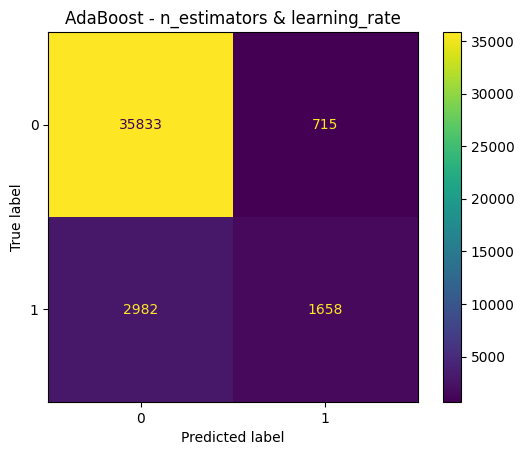

In [20]:
for result in all_results:
    estimator = result['best_estimator']
    y_pred = estimator.predict(X[estimator.feature_names_in_])
    cm = confusion_matrix(y, y_pred, labels =estimator.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
    disp.plot()
    plt.title(result['experiment_name'])

{'model': Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('model',
                  RandomForestClassifier(class_weight='balanced_subsample',
                                         max_depth=15, min_samples_leaf=6,
                                         min_samples_split=15,
                                         random_state=42))]),
 'best_estimator': Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('model',
                  RandomForestClassifier(class_weight='balanced_subsample',
                                         max_depth=15, min_samples_leaf=6,
                                         min_samples_split=15,
                                         random_state=42))]),
 'experiment': 4,
 'experiment_name': 'Random Forest RFECV',
 'notes': 'RFECV selected 18 features',
 'train_accuracy': np.float64(0.8745),
 'test_accuracy': np.float64(0.8619),
 'test_accuracy_std': np.float64(0.0037),
 'train_precision': np.float64(0.4613),
 'test_precision'

Text(0.5, 1.0, 'RFECV Random Forest')

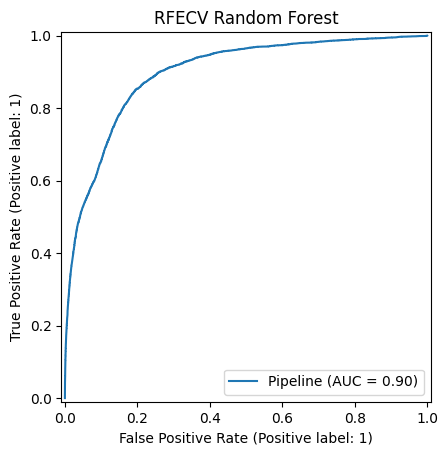

In [53]:
from sklearn.metrics import RocCurveDisplay

clf = result4['best_estimator']
y_pred_proba = clf.predict_proba(X[selected_features_rfecv])
y


RocCurveDisplay.from_estimator(clf, X[selected_features_rfecv], y)
plt.title('RFECV Random Forest')

array(['age', 'education_n', 'job_n', 'housing', 'loan', 'campaign_n',
       'previous', 'emp.var.rate', 'cons.conf.idx', 'euribor3m',
       'cons.price.idx', 'nr.employed', 'month_may', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_wed',
       'contact_n'], dtype=object)